Dans cette compétition il s'agit de prédire une série temporelle. Beaucoup d'approches économétriques sont admises telles que les modèles ARIMA, le lissage exponentiel, etc. Il est aussi possible d'utiliser des réseaux de neurones à convolution et des réseaux récurrents et évidemment tout modèle de régression ML.

Mais avant tout il est important de comprendre les données (cette tâche est laissée aux compétiteurs). Ici nous allons montrer comment apprendre un simple modèle en vue de faire une soumission. Notre hypothèse sous-jacente est que la consommation d'électricité dépend d'effets saisonniers capturés par le mois, d'éffets journaliers capturés par le jour et potentiellement une tendance capturée par l'année. Donc nos modèles prendront en entrée ces données. Nous les générons à l'aide de la fonction `ajout_details_date`.

In [1]:
import pandas as pd
import numpy as np

In [2]:
# Lecture du fichier d'entraînement
train = pd.read_csv("./data/train.csv")

# Lecture du fichier de test
test = pd.read_csv("./data/test.csv")

In [3]:
def ajout_details_date(df):
    df["Date"] = pd.to_datetime(df["Date"]) # conversion en date
    df["Mois"]= df.Date.dt.month # mois de l'année
    df["Jour_Semaine"] = df.Date.dt.dayofweek #jour de la semaine
    df["Jour_Mois"] = df.Date.dt.day # jour du mois
    df["Annee"] = df.Date.dt.year # année
    df["heure"] = df["Heure"].str[:2].astype(int)
    return df

train = ajout_details_date(train)
test = ajout_details_date(test)

In [4]:
train.head()

,Date,Heure,Consommation,Mois,Jour_Semaine,Jour_Mois,Annee,heure
0,2015-12-31,00:00,29590.88,12,3,31,2015,0
1,2015-12-31,01:00,27785.43,12,3,31,2015,1
2,2015-12-31,02:00,26516.53,12,3,31,2015,2
3,2015-12-31,03:00,26091.62,12,3,31,2015,3
4,2015-12-31,04:00,25871.54,12,3,31,2015,4


## A- REGRESSION LINEAIRE REGULARISEE (RIDGE ou LASSO)

Ici on va se servir des variables catégorielles Mois, Jour_Semaine, Jour_Mois, Annee et Heure. Il nous faut donc les transformer en variables dummy

In [5]:
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import mean_absolute_error
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import matplotlib.pyplot as plt

In [6]:
# CALCUL DE FEATURES
df_tr = train.copy()
df_te = test.copy()
# identifier les données
df_tr["train"] = 1
df_te["train"] = 0
df = df_tr.append(df_te).reset_index(drop=True)

#"""
CATVARS = ["Mois", "Jour_Semaine", "Annee","heure"]
FE = ["Jour_Mois"]
for col in CATVARS:
    temp = pd.get_dummies(df[col], prefix=col)
    cols = list(temp.columns)
    FE += cols
    df = df.join(temp)
#"""
df_te = df.loc[df.train==0].copy().reset_index(drop=True)
df_tr = df.loc[df.train==1].copy().reset_index(drop=True)
del df

In [7]:
df_tr.shape, df_te.shape

((36528, 58), (2928, 58))

In [8]:
X = df_tr[FE].values
Xe = df_te[FE].values
y = df_tr["Consommation"].values

In [9]:
df_tr["Cluster"] = (df_tr["Mois"].astype(str) + "_" + df_tr["Jour_Semaine"].astype(str) 
                    +  "_" + df_tr["Heure"] )

In [10]:
NFOLDS = 5
skf = StratifiedKFold(n_splits=NFOLDS)
folds = list(skf.split(X, df_tr["Cluster"].values))

In [11]:
oof = np.zeros(y.shape)
pred = np.zeros((Xe.shape[0], ))

print("="*50)
for idx in range(NFOLDS):
    tr_idx, val_idx = folds[idx]
    #reg = LinearRegression()
    reg = Ridge()
    reg.fit(X[tr_idx], y[tr_idx])
    oof[val_idx] = reg.predict(X[val_idx])
    pred += reg.predict(Xe) / NFOLDS
    print(f"FOLD {idx +1} MAE:", mean_absolute_error(y[val_idx], oof[val_idx]))
    print("="*50)
#===============
print("GLOBAL MAE:", mean_absolute_error(y, oof))

FOLD 1 MAE: 1960.763088481883
FOLD 2 MAE: 1644.1523953602655
FOLD 3 MAE: 1832.3914534566907
FOLD 4 MAE: 1918.9646010209613
FOLD 5 MAE: 1900.451445568609
GLOBAL MAE: 1851.3414012330852


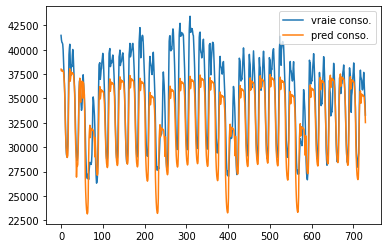

In [12]:
plt.plot(y[-365*2:], label="vraie conso.")
plt.plot(oof[-365*2:], label="pred conso.")
plt.legend(loc="best")
plt.show()

On voit qu'on arrive à repliquer la tendance, mais par définion la regression cible la moyenne. Par ailleurs avec la métrique MAE on cible la médiane. **Donc il serait intéressant de faire une regression quantile**.

In [13]:
df_te["Ridge"] = pred
df_tr["Ridge"] = oof
#df_te[["Date","Heure","Consommation"]].to_csv("./subs/ols.csv", index=False)

## B- RESEAU DE NEURONES

In [14]:
import tensorflow as tf
import tensorflow.keras.layers as L
import tensorflow.keras.models as M

from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping

In [15]:
def build_model(n_in):
    inp = L.Input(name="inputs", shape=(n_in,))
    x = L.Dense(100, activation="relu", name="d1")(inp)
    x = L.Dense(100, activation="relu", name="d2")(x)
    
    preds = L.Dense(1, activation="linear", name="preds")(x)
    
    model = M.Model(inp, preds, name="ANN1")
    model.compile(loss="mae", optimizer="adam")
    return model
#=====================
net = build_model(X.shape[1])
print(net.summary())

Model: "ANN1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inputs (InputLayer)          [(None, 50)]              0         
_________________________________________________________________
d1 (Dense)                   (None, 100)               5100      
_________________________________________________________________
d2 (Dense)                   (None, 100)               10100     
_________________________________________________________________
preds (Dense)                (None, 1)                 101       
Total params: 15,301
Trainable params: 15,301
Non-trainable params: 0
_________________________________________________________________
None


In [16]:
X = df_tr[FE].values
Xe = df_te[FE].values
y = df_tr["Consommation"].values

scaler = MinMaxScaler()
X = scaler.fit_transform(X)
Xe = scaler.transform(Xe)

In [17]:
oof = np.zeros(y.shape)
pred = np.zeros((Xe.shape[0], ))

print("="*50)
for idx in range(NFOLDS):
    tr_idx, val_idx = folds[idx]
    
    ckpt = ModelCheckpoint(f"w{idx}.h5", monitor='val_loss', verbose=0, save_best_only=True,mode='min')
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2,patience=3, min_lr=0.0005)
    es = EarlyStopping(monitor='val_loss', patience=6)
    
    reg = build_model(X.shape[1])
    reg.fit(X[tr_idx], y[tr_idx], epochs=120, batch_size=512, 
            validation_data=(X[val_idx], y[val_idx]), verbose=0, callbacks=[ckpt, reduce_lr, es])
    reg.load_weights(f"w{idx}.h5")
    oof[val_idx] = reg.predict(X[val_idx])[:,0]
    pred += reg.predict(Xe)[:,0] / NFOLDS
    print(f"FOLD {idx +1} MAE:", mean_absolute_error(y[val_idx], oof[val_idx]))
    print("="*50)
#===============
print("GLOBAL MAE:", mean_absolute_error(y, oof))

FOLD 1 MAE: 1857.7399311674478
FOLD 2 MAE: 1572.2687060399842
FOLD 3 MAE: 1696.3769733459658
FOLD 4 MAE: 1887.1097910784563
FOLD 5 MAE: 1804.377276276951
GLOBAL MAE: 1763.5700366221631


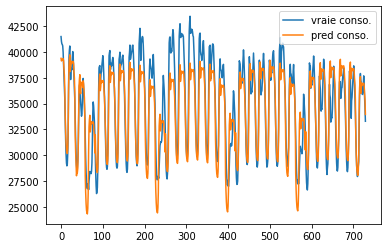

In [18]:
plt.plot(y[-365*2:], label="vraie conso.")
plt.plot(oof[-365*2:], label="pred conso.")
plt.legend(loc="best")
plt.show()

In [19]:
df_te["Ann"] = pred
df_tr["Ann"] = oof

## C- BOOSTING MODELS (LightGBM)

In [20]:
import lightgbm as lgb

In [21]:
PARAMS = {
 'objective':'mae',
 'reg_alpha': 0.1,
 'reg_lambda': 0.1, 
 'n_estimators': 100,
 'learning_rate': 0.05,
 'random_state': 42,
 "num_leaves": 128, 
 "verbose":-1
}

NUMCOLS = ["Jour_Mois"]
CATCOLS = ["Mois", "Jour_Semaine", "Annee","heure"]

In [22]:
oof = np.zeros(y.shape)
pred = np.zeros((Xe.shape[0], ))
tgt_col = "Consommation"
ROUNDS = 200

print("="*50)
for idx in range(NFOLDS):
    tr_idx, val_idx = folds[idx]
    lgb_tr = lgb.Dataset(train.iloc[tr_idx][NUMCOLS + CATCOLS], train.iloc[tr_idx][tgt_col])
    lgb_val = lgb.Dataset(train.iloc[val_idx][NUMCOLS + CATCOLS], train.iloc[val_idx][tgt_col])
    model = lgb.train(PARAMS, lgb_tr,valid_sets=[lgb_tr, lgb_val],verbose_eval=5, 
                      num_boost_round=ROUNDS,early_stopping_rounds=50)
    oof[val_idx] = model.predict(train.iloc[val_idx][NUMCOLS + CATCOLS])
    pred += model.predict(test[NUMCOLS + CATCOLS]) / NFOLDS
    print(f"FOLD {idx +1} MAE:", mean_absolute_error(y[val_idx], oof[val_idx]))
    print("="*50)
#===============
print("GLOBAL MAE:", mean_absolute_error(y, oof))

Training until validation scores don't improve for 50 rounds
[5]	training's l1: 3231.83	valid_1's l1: 3740.98
[10]	training's l1: 2657.11	valid_1's l1: 3309.9
[15]	training's l1: 2228.11	valid_1's l1: 2986.45
[20]	training's l1: 1899.14	valid_1's l1: 2722.42
[25]	training's l1: 1647.1	valid_1's l1: 2486.28
[30]	training's l1: 1456.19	valid_1's l1: 2320.54
[35]	training's l1: 1315.42	valid_1's l1: 2167.38
[40]	training's l1: 1209.34	valid_1's l1: 2054

C:\Users\A104421\Anaconda3\envs\dl\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))



[45]	training's l1: 1121.15	valid_1's l1: 1962.49
[50]	training's l1: 1052.06	valid_1's l1: 1872.73
[55]	training's l1: 995.649	valid_1's l1: 1775.37
[60]	training's l1: 949.077	valid_1's l1: 1720.08
[65]	training's l1: 906.262	valid_1's l1: 1676.97
[70]	training's l1: 867.324	valid_1's l1: 1641.67
[75]	training's l1: 832.625	valid_1's l1: 1603.6
[80]	training's l1: 803.705	valid_1's l1: 1570.03
[85]	training's l1: 779.197	valid_1's l1: 1546.53
[90]	training's l1: 756.233	valid_1's l1: 1530.91
[95]	training's l1: 735.773	valid_1's l1: 1498.2
[100]	training's l1: 712.927	valid_1's l1: 1493.9
Did not meet early stopping. Best iteration is:
[100]	training's l1: 712.927	valid_1's l1: 1493.9
FOLD 1 MAE: 1493.8989373810662
Training until validation scores don't improve for 50 rounds
[5]	training's l1: 3318.86	valid_1's l1: 3336.03
[10]	training's l1: 2751.36	valid_1's l1: 2764.08
[15]	training's l1: 2310.77	valid_1's l1: 2331.35
[20]	training's l1: 1978.6	valid_1's l1: 2013.72
[25]	training

C:\Users\A104421\Anaconda3\envs\dl\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))



[40]	training's l1: 1268.63	valid_1's l1: 1355.68
[45]	training's l1: 1181.52	valid_1's l1: 1279.59
[50]	training's l1: 1106.55	valid_1's l1: 1213.28
[55]	training's l1: 1042.36	valid_1's l1: 1164.75
[60]	training's l1: 992.951	valid_1's l1: 1125.03
[65]	training's l1: 946.537	valid_1's l1: 1095.87
[70]	training's l1: 914.277	valid_1's l1: 1069.57
[75]	training's l1: 879.472	valid_1's l1: 1055.17
[80]	training's l1: 852.082	valid_1's l1: 1037.05
[85]	training's l1: 821.636	valid_1's l1: 1021.23
[90]	training's l1: 800.071	valid_1's l1: 1010.96
[95]	training's l1: 778.319	valid_1's l1: 998.627
[100]	training's l1: 758.446	valid_1's l1: 988.461
Did not meet early stopping. Best iteration is:
[100]	training's l1: 758.446	valid_1's l1: 988.461
FOLD 2 MAE: 988.4604898870974
Training until validation scores don't improve for 50 rounds
[5]	training's l1: 3316.75	valid_1's l1: 3326.99
[10]	training's l1: 2749.5	valid_1's l1: 2764.63
[15]	training's l1: 2322.51	valid_1's l1: 2352.8
[20]	traini

C:\Users\A104421\Anaconda3\envs\dl\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))



[40]	training's l1: 1269.36	valid_1's l1: 1419.41
[45]	training's l1: 1178.24	valid_1's l1: 1350.81
[50]	training's l1: 1103.56	valid_1's l1: 1294.01
[55]	training's l1: 1033.33	valid_1's l1: 1247.49
[60]	training's l1: 985.302	valid_1's l1: 1210.05
[65]	training's l1: 937.505	valid_1's l1: 1181.64
[70]	training's l1: 901.262	valid_1's l1: 1154
[75]	training's l1: 867.432	valid_1's l1: 1131.07
[80]	training's l1: 835.509	valid_1's l1: 1113.78
[85]	training's l1: 809.695	valid_1's l1: 1096.64
[90]	training's l1: 787.695	valid_1's l1: 1082.42
[95]	training's l1: 767.462	valid_1's l1: 1068.99
[100]	training's l1: 743.132	valid_1's l1: 1053.63
Did not meet early stopping. Best iteration is:
[100]	training's l1: 743.132	valid_1's l1: 1053.63
FOLD 3 MAE: 1053.6288457453838
Training until validation scores don't improve for 50 rounds
[5]	training's l1: 3296.89	valid_1's l1: 3299.53
[10]	training's l1: 2706.01	valid_1's l1: 2738.33
[15]	training's l1: 2260.54	valid_1's l1: 2351.23
[20]	traini

C:\Users\A104421\Anaconda3\envs\dl\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))



[35]	training's l1: 1317.2	valid_1's l1: 1574.48
[40]	training's l1: 1205.18	valid_1's l1: 1495.02
[45]	training's l1: 1118.08	valid_1's l1: 1432.1
[50]	training's l1: 1043.28	valid_1's l1: 1382.33
[55]	training's l1: 982.497	valid_1's l1: 1343.37
[60]	training's l1: 930.607	valid_1's l1: 1311.41
[65]	training's l1: 888.55	valid_1's l1: 1287.95
[70]	training's l1: 851.495	valid_1's l1: 1261.63
[75]	training's l1: 815.502	valid_1's l1: 1241.41
[80]	training's l1: 787.195	valid_1's l1: 1225.31
[85]	training's l1: 764.013	valid_1's l1: 1216.07
[90]	training's l1: 740.834	valid_1's l1: 1206.02
[95]	training's l1: 715.046	valid_1's l1: 1187.91
[100]	training's l1: 694.642	valid_1's l1: 1177.29
Did not meet early stopping. Best iteration is:
[100]	training's l1: 694.642	valid_1's l1: 1177.29
FOLD 4 MAE: 1177.289963913206
Training until validation scores don't improve for 50 rounds
[5]	training's l1: 3326.65	valid_1's l1: 3177.03
[10]	training's l1: 2728.17	valid_1's l1: 2651.87
[15]	trainin

C:\Users\A104421\Anaconda3\envs\dl\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))



[45]	training's l1: 1141.38	valid_1's l1: 1607.8
[50]	training's l1: 1070.43	valid_1's l1: 1576.86
[55]	training's l1: 1012.67	valid_1's l1: 1554.28
[60]	training's l1: 964.464	valid_1's l1: 1539.54
[65]	training's l1: 916.828	valid_1's l1: 1524.6
[70]	training's l1: 876.321	valid_1's l1: 1518.79
[75]	training's l1: 841.654	valid_1's l1: 1511.78
[80]	training's l1: 807.52	valid_1's l1: 1501.88
[85]	training's l1: 781.722	valid_1's l1: 1494.9
[90]	training's l1: 754.768	valid_1's l1: 1494.04
[95]	training's l1: 728.555	valid_1's l1: 1495
[100]	training's l1: 707.508	valid_1's l1: 1492.02
Did not meet early stopping. Best iteration is:
[100]	training's l1: 707.508	valid_1's l1: 1492.02
FOLD 5 MAE: 1492.017367732383
GLOBAL MAE: 1241.0539963947658


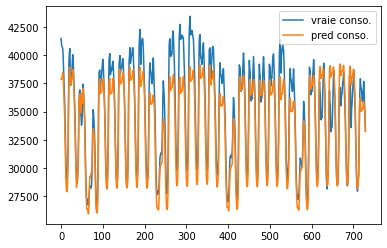

In [23]:
plt.plot(y[-365*2:], label="vraie conso.")
plt.plot(oof[-365*2:], label="pred conso.")
plt.legend(loc="best")
plt.show()

In [24]:
df_te["Lgbm"] = pred
df_tr["Lgbm"] = oof

## D-RANDOM FOREST

In [25]:
from sklearn.ensemble import RandomForestRegressor

In [26]:
X = df_tr[NUMCOLS + CATCOLS].values
Xe = df_te[NUMCOLS + CATCOLS].values
y = df_tr["Consommation"].values

In [27]:
oof = np.zeros(y.shape)
pred = np.zeros((Xe.shape[0], ))

print("="*50)
for idx in range(NFOLDS):
    tr_idx, val_idx = folds[idx]
    reg = RandomForestRegressor(max_depth=15, n_estimators=50)#, criterion="mae"
    reg.fit(X[tr_idx], y[tr_idx])
    oof[val_idx] = reg.predict(X[val_idx])
    pred += reg.predict(Xe) / NFOLDS
    print(f"FOLD {idx +1} MAE:", mean_absolute_error(y[val_idx], oof[val_idx]))
    print("="*50)
#===============
print("GLOBAL MAE:", mean_absolute_error(y, oof))

FOLD 1 MAE: 1856.023534396001
FOLD 2 MAE: 995.514165419657
FOLD 3 MAE: 1021.586703502118
FOLD 4 MAE: 1251.0175365688049
FOLD 5 MAE: 1810.467782168463
GLOBAL MAE: 1386.9140698646358


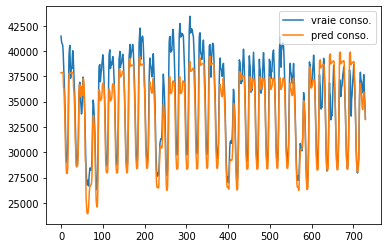

In [28]:
plt.plot(y[-365*2:], label="vraie conso.")
plt.plot(oof[-365*2:], label="pred conso.")
plt.legend(loc="best")
plt.show()

In [29]:
df_te["rf"] = pred
df_tr["rf"] = oof

## CORRELATION ENTRE MODELS ET BAGGING

On voit que le LGBM est le plus correlé à la cible et est relativement moins correlés aux modèles RIDGE et ANN. Ainsi baggant ces prédictions on peut améliorer notre score.

In [30]:
df_tr["ID"] = np.arange(df_tr.shape[0])

In [31]:
df_tr[["Ann","Ridge","Lgbm","rf","Consommation"]].corr()

,Ann,Ridge,Lgbm,rf,Consommation
Ann,1.000000,0.991837,0.925261,0.873504,0.856433
Ridge,0.991837,1.000000,0.924912,0.876137,0.846556
Lgbm,0.925261,0.924912,1.000000,0.960169,0.899772
rf,0.873504,0.876137,0.960169,1.000000,0.870370
Consommation,0.856433,0.846556,0.899772,0.870370,1.000000


In [32]:
df_te[["Ann","Ridge","Lgbm","rf"]].corr()

,Ann,Ridge,Lgbm,rf
Ann,1.000000,0.997388,0.904264,0.778571
Ridge,0.997388,1.000000,0.912189,0.793413
Lgbm,0.904264,0.912189,1.000000,0.928819
rf,0.778571,0.793413,0.928819,1.000000


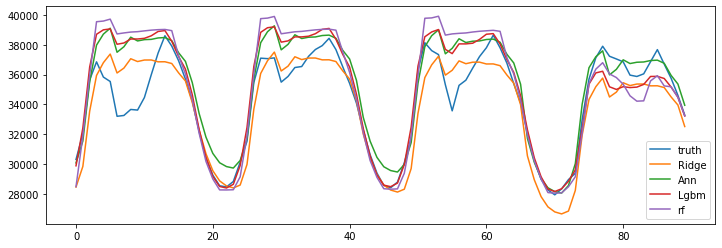

In [33]:
kx = 90
plt.figure(figsize=(12,4))
plt.plot(df_tr.iloc[-kx:]["Consommation"].values, label="truth")
plt.plot(df_tr.iloc[-kx:]["Ridge"].values, label="Ridge")
plt.plot(df_tr.iloc[-kx:]["Ann"].values, label="Ann")
plt.plot(df_tr.iloc[-kx:]["Lgbm"].values, label="Lgbm")
plt.plot(df_tr.iloc[-kx:]["rf"].values, label="rf")
plt.legend(loc="best")
plt.show()

In [34]:
bW = [0.7,0.025,0.025,0.25] # Poids de Bagging

df_tr["blend"] = (bW[0] * df_tr["Lgbm"] + bW[1] * df_tr["Ann"] + bW[2] * df_tr["Ridge"] + bW[3] * df_tr["rf"])
df_te["blend"] = (bW[0] * df_te["Lgbm"] + bW[1] * df_te["Ann"] + bW[2] * df_te["Ridge"] + bW[3] * df_te["rf"])

for model in ["Ridge", "Ann", "Lgbm", "rf","blend"]:
    print(model, "MAE:", mean_absolute_error(df_tr[tgt_col], df_tr[model]))

Ridge MAE: 1851.3414012330852
Ann MAE: 1763.5700366221631
Lgbm MAE: 1241.0539963947658
rf MAE: 1386.9140698646358
blend MAE: 1225.661882758672


On note que bagger plusieurs modèles ont fait baisser le MAE de 1241 à 1225.

In [35]:
sub = df_te[["Date","Heure","blend"]].copy()
sub = sub.rename(columns={"blend":"Consommation"})
sub.to_csv("./subs/sample_submission.csv", index=False)